# Financial Accounting ML

The aim of this notebook is to explore the application of various Machine Learning tools in relation to the Financial Account dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans
import matplotlib.dates as mdates
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv('../data/double_entry_financial_accounting.csv')
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df['Date'] = df['Date'] - pd.DateOffset(years=1)
df.rename(columns={'Transaction_Type': 'Transaction Type', 'Payment_Method': 'Payment Method'}, inplace=True)

In [5]:
df.head()

,Date,Account,Debit,Credit,Category,Transaction Type,Customer_Vendor,Payment Method
0,2022-03-15,Accounts Receivable,274.79,0.00,Asset,Transfer,Customer 47,Cash
1,2022-03-15,Expense Account,0.00,274.79,Expense,Transfer,Customer 47,Cash
2,2022-12-06,Accounts Receivable,777.34,0.00,Asset,Sale,Customer 9,Credit Card
3,2022-12-06,Liability Account,0.00,777.34,Liability,Sale,Customer 9,Credit Card
4,2022-04-16,Accounts Receivable,566.85,0.00,Asset,Sale,Customer 2,Credit Card


## Classification

In [6]:
classification_models = []

### Acccount

In [7]:
df_classify = df.copy()
label_encoders = {}
for column in ['Transaction Type', 'Category', 'Customer_Vendor', 'Payment Method']:
    le = LabelEncoder()
    df_classify[column] = le.fit_transform(df_classify[column])
    label_encoders[column] = le

features = ['Transaction Type', 'Category', 'Customer_Vendor', 'Payment Method', 'Debit', 'Credit']
account_X = df_classify[features]
account_y = df_classify['Account']

account_X_train, account_X_test, account_y_train, account_y_test = train_test_split(account_X, account_y, test_size=0.3, random_state=42)

account_classification_model = RandomForestClassifier(random_state=42)
account_classification_model.fit(account_X_train, account_y_train)

account_y_pred = account_classification_model.predict(account_X_test)
print(classification_report(account_y_test, account_y_pred))
classification_models.append(account_classification_model)

                     precision    recall  f1-score   support

   Accounts Payable       0.53      0.47      0.50      8428
Accounts Receivable       0.45      0.52      0.48      7509
      Asset Account       0.12      0.09      0.10      3688
               Cash       0.45      0.49      0.47     10310
    Expense Account       0.87      0.88      0.88      7356
          Inventory       0.31      0.28      0.29      9574
  Liability Account       0.63      0.67      0.65      5640
    Revenue Account       0.24      0.13      0.17      1892
      Sales Revenue       0.75      0.86      0.80      5603

           accuracy                           0.52     60000
          macro avg       0.48      0.49      0.48     60000
       weighted avg       0.51      0.52      0.51     60000



### Transaction Type

In [8]:
df_classify = df.copy()
label_encoders = {}
for column in ['Category', 'Account', 'Customer_Vendor', 'Payment Method']:
    le = LabelEncoder()
    df_classify[column] = le.fit_transform(df_classify[column])
    label_encoders[column] = le

features = ['Category', 'Account', 'Customer_Vendor', 'Payment Method', 'Debit', 'Credit']
transaction_type_X = df_classify[features]
transaction_type_y = df_classify['Transaction Type']

transaction_type_X_train, transaction_type_X_test, transaction_type_y_train, transaction_type_y_test = train_test_split(transaction_type_X, transaction_type_y, test_size=0.3, random_state=42)

transaction_type_classification_model = RandomForestClassifier(random_state=42)
transaction_type_classification_model.fit(transaction_type_X_train, transaction_type_y_train)

transaction_type_y_pred = transaction_type_classification_model.predict(transaction_type_X_test)
print(classification_report(transaction_type_y_test, transaction_type_y_pred))
classification_models.append(transaction_type_classification_model)

              precision    recall  f1-score   support

     Expense       0.27      0.28      0.28     14904
    Purchase       0.27      0.27      0.27     15021
        Sale       0.27      0.27      0.27     15088
    Transfer       0.27      0.27      0.27     14987

    accuracy                           0.27     60000
   macro avg       0.27      0.27      0.27     60000
weighted avg       0.27      0.27      0.27     60000



### Category

In [10]:
df_classify = df.copy()
label_encoders = {}
for column in ['Transaction Type', 'Account', 'Customer_Vendor', 'Payment Method']:
    le = LabelEncoder()
    df_classify[column] = le.fit_transform(df_classify[column])
    label_encoders[column] = le

features = ['Account', 'Customer_Vendor', 'Transaction Type', 'Payment Method', 'Debit', 'Credit']
category_X = df_classify[features]
category_y = df_classify['Category']

category_X_train, category_X_test, category_y_train, category_y_test = train_test_split(category_X, category_y, test_size=0.3, random_state=42)

category_classification_model = RandomForestClassifier(random_state=42)
category_classification_model.fit(category_X_train, category_y_train)

category_y_pred = category_classification_model.predict(category_X_test)
print(classification_report(category_y_test, category_y_pred))
classification_models.append(category_classification_model)

              precision    recall  f1-score   support

       Asset       0.94      0.96      0.95     32128
     Expense       0.89      0.84      0.87      9166
   Liability       0.78      0.79      0.78      9300
     Revenue       0.90      0.90      0.90      9406

    accuracy                           0.90     60000
   macro avg       0.88      0.87      0.87     60000
weighted avg       0.90      0.90      0.90     60000



## Anomaly Detection
Having trained the classification models, we can leverage them to detect potentially anomalous classifications in the data. In this implementation, we create a dataframe of transactions for which the classsifification model is unable to assign a clear class with high confidence. If the highest probability for every class within a transaction is below a certain threshold, it is automatically flagged as anunusual transactions. Such transactions are flagged as potentially anomalous for further investigation.

In [11]:
# Example with category classification model
model = category_classification_model
probabilities = model.predict_proba(category_X_test)
threshold = 0.3 # 30% threshold, dependent on business requirements

suspicious_indices = []
for i, probs in enumerate(probabilities):
    if max(probs) < threshold:
        suspicious_indices.append(i)

df_suspicious = transaction_type_X_test.iloc[suspicious_indices]
print("Suspicious Transactions:")
df_suspicious = df.loc[df_suspicious.index]
df_suspicious

Suspicious Transactions:


,Date,Account,Debit,Credit,Category,Transaction Type,Customer_Vendor,Payment Method


## Clustering

### Account

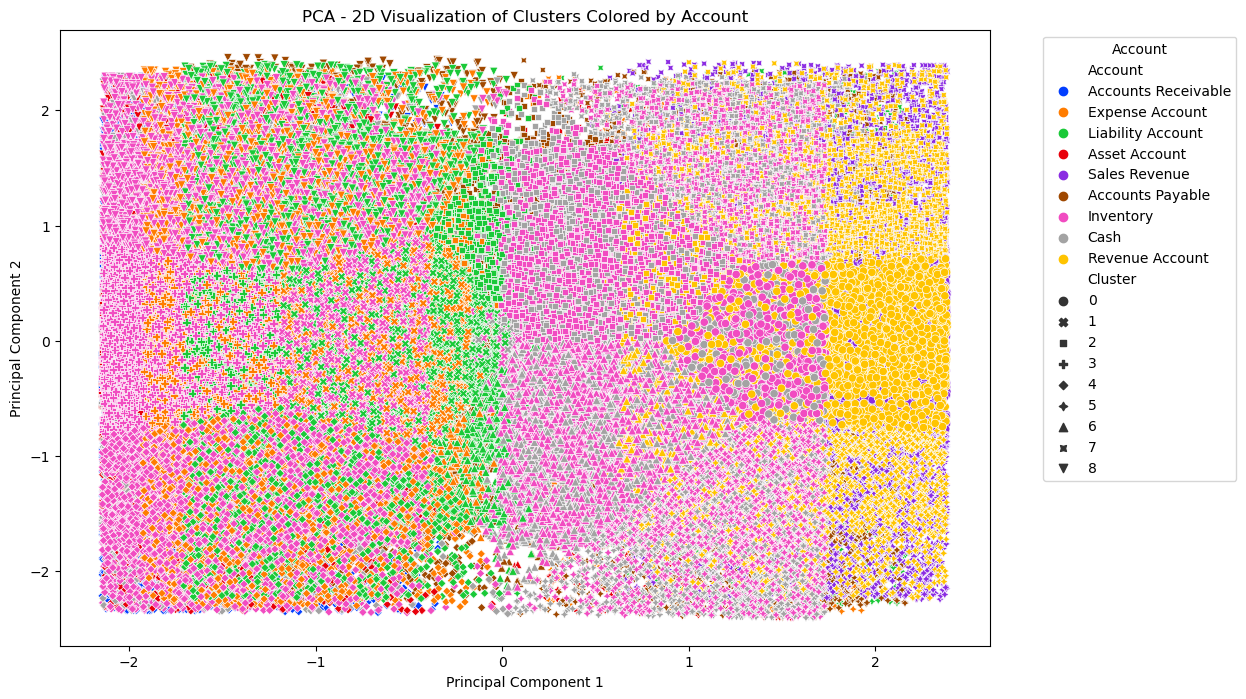

In [12]:
df_cluster = df.copy()
df_cluster = df_cluster.drop('Date', axis=1)

label_encoders = {}
for column in df_cluster.select_dtypes(include=['object']).columns:
    if column != 'Account':
        le = LabelEncoder()
        df_cluster[column] = le.fit_transform(df_cluster[column])
        label_encoders[column] = le

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_cluster.drop('Account', axis=1))

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

kmeans = KMeans(n_clusters=df.Account.nunique(), random_state=42)
kmeans.fit(pca_features)
df_cluster['Cluster'] = kmeans.labels_

plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], 
                hue=df_cluster['Account'], palette='bright', 
                style=df_cluster['Cluster'])
plt.title('PCA - 2D Visualization of Clusters Colored by Account')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Account', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Payment Method

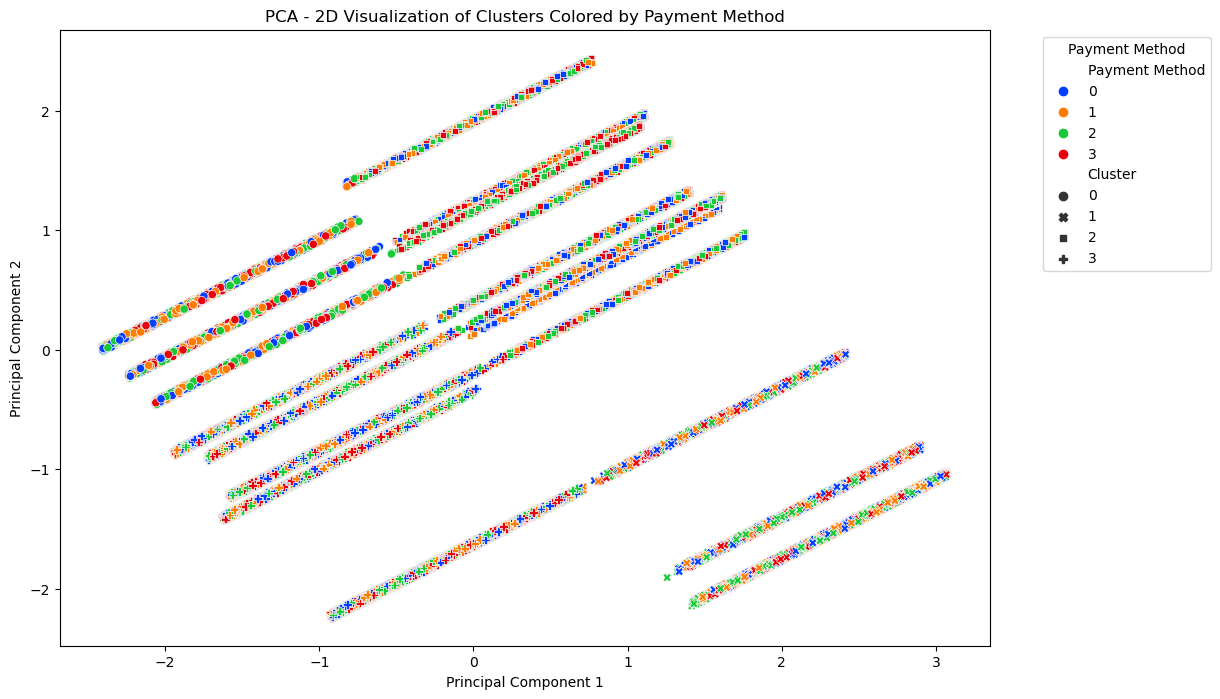

In [13]:
df_cluster = df.copy()
df_cluster = df_cluster.drop('Date', axis=1)

label_encoders = {}
for column in df_cluster.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_cluster[column] = le.fit_transform(df_cluster[column])
    label_encoders[column] = le

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_cluster.drop(['Payment Method'], axis=1))

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

kmeans = KMeans(n_clusters=df['Payment Method'].nunique(), random_state=42)
kmeans.fit(pca_features)
df_cluster['Cluster'] = kmeans.labels_

plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], 
                hue=df_cluster['Payment Method'], palette='bright', 
                style=df_cluster['Cluster'])
plt.title('PCA - 2D Visualization of Clusters Colored by Payment Method')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Payment Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Transaction Type

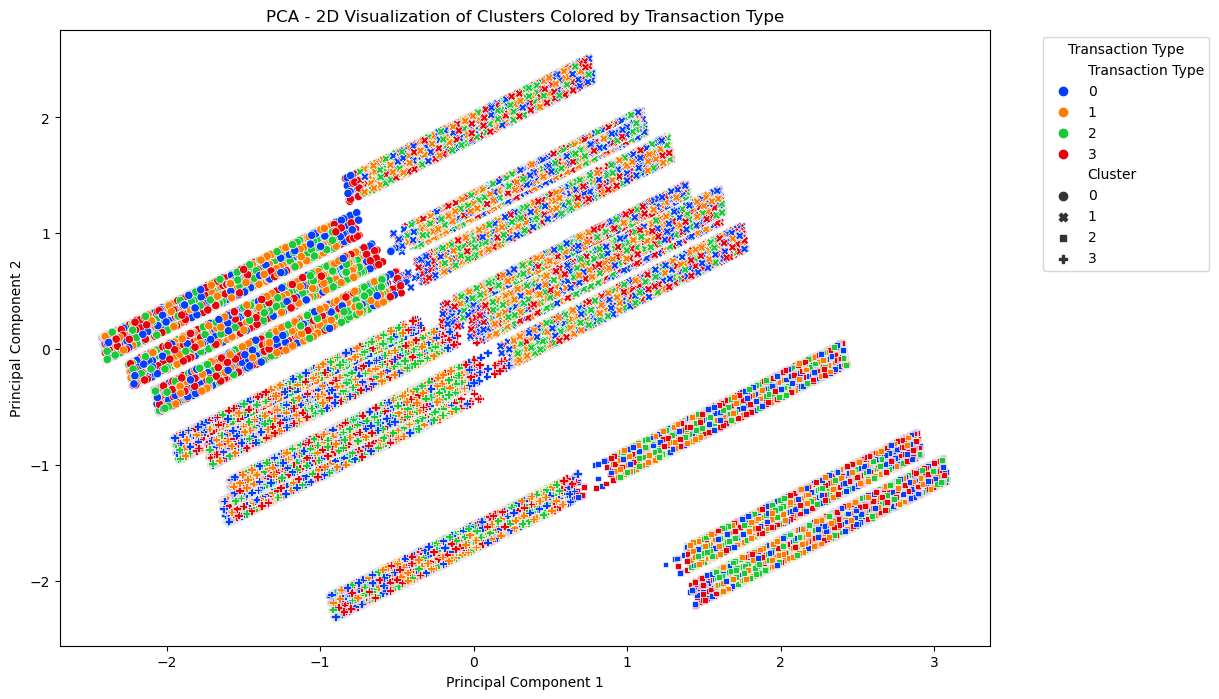

In [14]:
df_cluster = df.copy()
df_cluster = df_cluster.drop('Date', axis=1)

label_encoders = {}
for column in df_cluster.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_cluster[column] = le.fit_transform(df_cluster[column])
    label_encoders[column] = le

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_cluster.drop('Transaction Type', axis=1))

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

kmeans = KMeans(n_clusters=df['Transaction Type'].nunique(), random_state=42)
kmeans.fit(pca_features)
df_cluster['Cluster'] = kmeans.labels_

plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], 
                hue=df_cluster['Transaction Type'], palette='bright', 
                style=df_cluster['Cluster'])
plt.title('PCA - 2D Visualization of Clusters Colored by Transaction Type')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Transaction Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Category

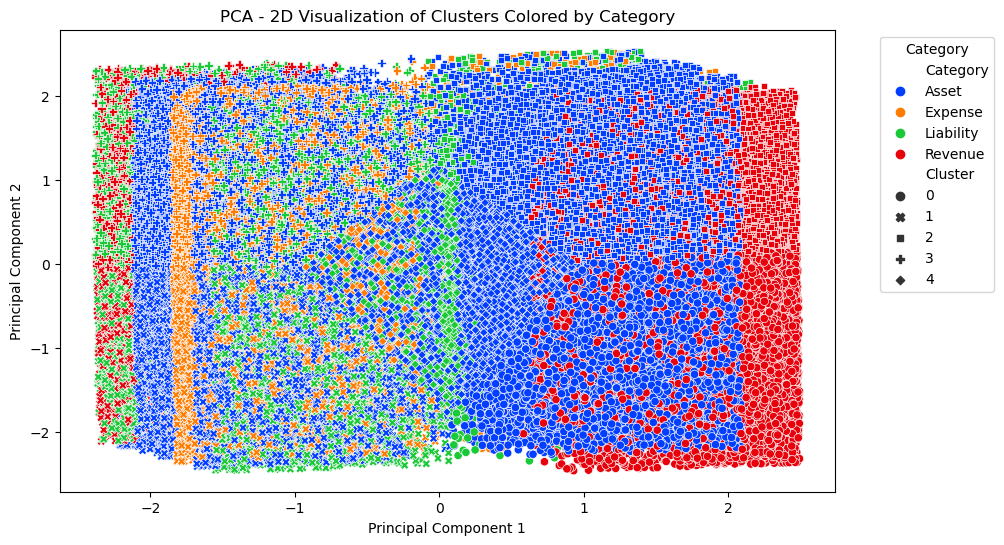

In [15]:
df_cluster = df.copy()
df_cluster = df_cluster.drop('Date', axis=1)

label_encoders = {}
for column in df_cluster.select_dtypes(include=['object']).columns:
    if column != 'Category':
        le = LabelEncoder()
        df_cluster[column] = le.fit_transform(df_cluster[column])
        label_encoders[column] = le

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_cluster.drop('Category', axis=1))

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(pca_features)
df_cluster['Cluster'] = kmeans.labels_

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], 
                hue=df_cluster['Category'], palette='bright',
                style=df_cluster['Cluster'])
plt.title('PCA - 2D Visualization of Clusters Colored by Category')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()